# Support Vector Machines


<h2>Introduction</h2>
There are two parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS

2. A part on features mapping

Data are 2D. You can visualize them by running the following cell (red dots are labeled -1 and green dots are labeled 1).

/Users/a/Eurecom/MALIS/lab3/data/dataset1.txt


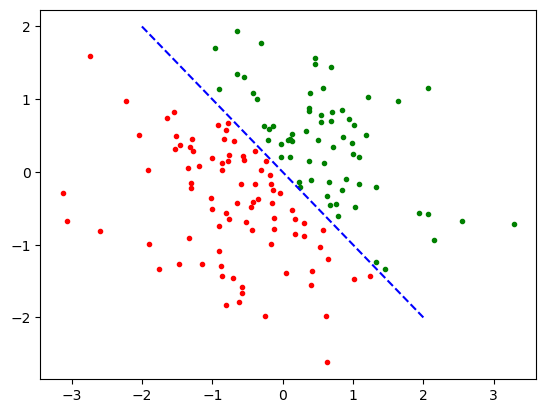

/Users/a/Eurecom/MALIS/lab3/data/dataset2.txt


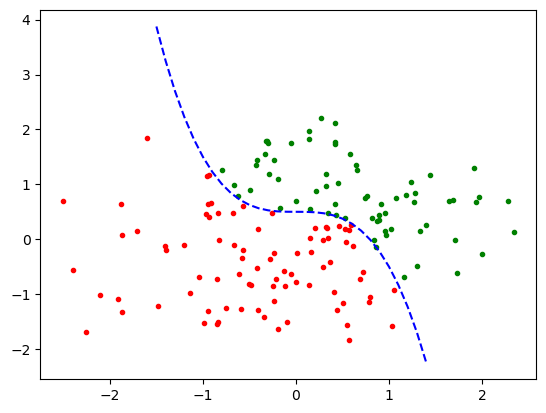

/Users/a/Eurecom/MALIS/lab3/data/dataset3.txt


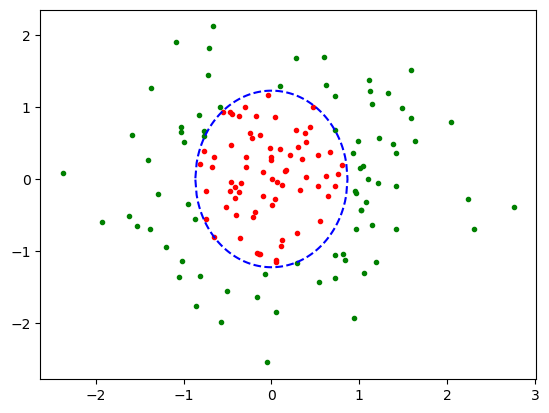

/Users/a/Eurecom/MALIS/lab3/data/dataset4.txt


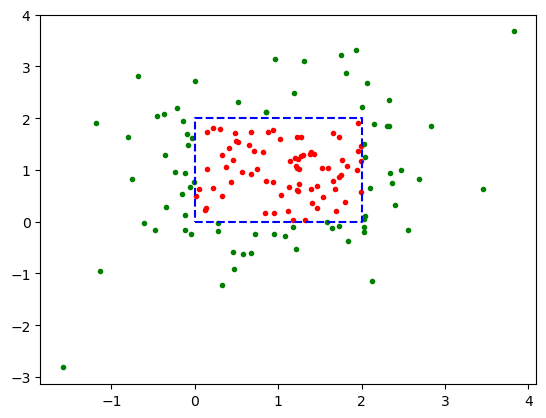

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt, cos, pi
import pandas as pd

# print the datasets and their delimiters
datasets = ["/Users/a/Eurecom/MALIS/lab3/data/dataset" + str(x) + ".txt" for x in range(1, 5)]
for dataset in datasets :
    print(dataset)
    points_df=pd.read_csv(dataset,delimiter = ' ')
    plt.plot(points_df.x_1[points_df.y==-1],points_df.x_2[points_df.y==-1],'r.') # points whose target y is -1
    plt.plot(points_df.x_1[points_df.y==1],points_df.x_2[points_df.y==1],'g.') # points whose target y is +1
    # draw exact delimiter
    if dataset == datasets[0]:
        plt.plot(np.array([0,40])/10-2,-np.array([0,40])/10+2, 'b--')
    elif dataset == datasets[1]:
        plt.plot([x/10-1.5 for x in range(30)], [0.5-((x/10)-1.5)**3 for x in range(30)], 'b--')
    elif dataset == datasets[2]:
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [-np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
    elif dataset == datasets[3]:
        plt.plot([x/8 for x in range(17)] + [2 for x in range(17)] + [(2-x/8) for x in range(17)] + [0 for x in range(17)],
             [0 for y in range(17)] + [y/8 for y in range(17)] + [2 for y in range(17)] + [(2-y/8) for y in range(17)], 'b--')
    plt.show()
    

### Question 0.1
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

Your answer here:

1.  **Dataset 1 (`/Users/a/Eurecom/MALIS/Lab3/data/dataset1.txt`)**: The first plot shows a clear linear boundary that can separate the two classes (red and green points). Therefore, this dataset appears to be linearly separable, and we would expect a linear SVM to perform well on this dataset.
    
2.  **Dataset 2 (`/Users/a/Eurecom/MALIS/Lab3/data/dataset2.txt`)**: The second plot shows a non-linear boundary (cubic) that suggests the dataset is not linearly separable. A linear SVM is likely to perform poorly on this dataset because it cannot capture the curve required to separate the classes effectively.
    
3.  **Dataset 3 (`/Users/a/Eurecom/MALIS/Lab3/data/dataset3.txt`)**: The third plot shows a circular boundary separating the two classes. This dataset is also not linearly separable since a straight line cannot divide the two classes without significant misclassification. A linear SVM will perform badly on this dataset as well.
    
4.  **Dataset 4 (`/Users/a/Eurecom/MALIS/Lab3/data/dataset4.txt`)**: The fourth plot suggests that the classes are separated by a square boundary. Similar to the second and third datasets, this dataset is not linearly separable because a linear SVM cannot conform to the square shape required to separate the classes properly. Thus, a linear SVM is expected to have poor performance on this dataset as well.
    

In summary, only `dataset1` seems to be linearly separable and suitable for a linear SVM. The remaining datasets have non-linear boundaries and would require either a non-linear SVM with an appropriate kernel or a feature transformation to map the data into a higher-dimensional space where it becomes linearly separable.

<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

<h3>Pseudo-code of PEGASOS</h3>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

### Exercise 1.1
Complete the following implementation of PEGASOS.

In [70]:
from utils import SVM, Dataset

def train(self, n_iterations, lambda_w, print_every_k=None,verbose=False):
    '''
    Train function for an SVM model using PEGASOS.
    If verbose is TRUE print the accuracy every 'print_every_k' iterations

    INPUTS:
    - self containing in particular:
        self.train_dataset with inside
            self.train_dataset.input -> inputs in a numpy NxD array, N number of sample, D dimensions
            self.train_dataset.output -> outputs in a numpy X array
        self.w -> weights of the model initialized at random before. Length D+1, because 1 is the bias
    - n_iterations -> total number of epochs
    - lambda_w -> lambda in PEGASOS
    - print_every_k -> compute the accuracy of the model every 'print_every_k' epochs
    - verbose -> if TRUE, in addition of computing the accuracy, the model also print it every 'print_every_k' epochs
    '''

    
    if not print_every_k:
        print_every_k = max(1, int(n_iterations/50))
        self.print_step=print_every_k
        # For n_iterations epochs
    for i in range(n_iterations): # equivalent for t in {1,...,T}

    # ! REMEMBER TO UPDATE self.w AT THE END OF EVERY ITERATION
    # ! self.train_dataset.input DOES NOT CONTAIN THE BIAS : a '1' in the dimension D+1
        # REMBER TO ADD THE '1' OF THE BIAS TO YOUR x VECTOR OR YOU WILL HAVE A SIZE MISMATCH
        # ADD THE BIAS IN THE LAST POSITION OF YOUR x VECTOR, OTHERWISE THE REST OF THE TRAIN WILL BE WRONG
        # x VECTOR OF [self.train_dataset.input[sample,:], 1]

    ################ YOUR CODE HERE #################
        # Pick a random sample (x, y) from the training dataset
        sample_index = np.random.randint(0, self.train_dataset.len)
        x = np.append(self.train_dataset.input[sample_index], 1)  # Add the bias term to the input
        y = self.train_dataset.output[sample_index]

        # Calculate the learning rate for this iteration.
        eta_t = 1 / (lambda_w * (i + 1))

        # Compute the sub-gradient and update the weights
        if y * np.dot(self.w, x) < 1:
            self.w = (1 - eta_t * lambda_w) * self.w + eta_t * y * x
        else:
            self.w = (1 - eta_t * lambda_w) * self.w


    ################ END OF YOUR CODE ###############
        
        if not i%print_every_k:
            if verbose:
                print("Epoch: ", i+1, " out of ", n_iterations)
                self.print_accuracy()
            else:
                self.compute_accuracy()
                    
SVM.train = train

### Question Exercise 1.2
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$).
You have to:

1. create 2 objects Dataset, with the train dataset and test dataset for each dataset in the folder data
2. initialize your SVM model with the 2 objects
3. use the train function of your SVM object to train it
4. use the make_plot function of your SVM object to make the plot of its accuracy
5. use the function print_accuracy of your SVM object to see the final training accuracy

**Note:** The data is already split. Have a look at the files in the data folder

Epoch:  1  out of  1500
Accuracy: 59.166666666666664 %
Epoch:  31  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  61  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  91  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  121  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  151  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  181  out of  1500
Accuracy: 93.33333333333333 %
Epoch:  211  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  241  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  271  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  301  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  331  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  361  out of  1500
Accuracy: 98.33333333333333 %
Epoch:  391  out of  1500
Accuracy: 88.33333333333333 %
Epoch:  421  out of  1500
Accuracy: 97.5 %
Epoch:  451  out of  1500
Accuracy: 97.5 %
Epoch:  481  out of  1500
Accuracy: 97.5 %
Epoch:  511  out of  1500
Accuracy: 95.0 %
Epoch:  541  out of  1500
Accuracy: 100.0 %
Epoc

Epoch:  1411  out of  1500
Accuracy: 90.83333333333333 %
Epoch:  1441  out of  1500
Accuracy: 94.16666666666667 %
Epoch:  1471  out of  1500
Accuracy: 92.5 %
Epoch:  1  out of  1500
Accuracy: 0.0 %
Epoch:  31  out of  1500
Accuracy: 61.66666666666667 %
Epoch:  61  out of  1500
Accuracy: 45.83333333333333 %
Epoch:  91  out of  1500
Accuracy: 65.83333333333333 %
Epoch:  121  out of  1500
Accuracy: 68.33333333333333 %
Epoch:  151  out of  1500
Accuracy: 50.83333333333333 %
Epoch:  181  out of  1500
Accuracy: 47.5 %
Epoch:  211  out of  1500
Accuracy: 41.66666666666667 %
Epoch:  241  out of  1500
Accuracy: 48.333333333333336 %
Epoch:  271  out of  1500
Accuracy: 48.333333333333336 %
Epoch:  301  out of  1500
Accuracy: 43.333333333333336 %
Epoch:  331  out of  1500
Accuracy: 62.5 %
Epoch:  361  out of  1500
Accuracy: 63.33333333333333 %
Epoch:  391  out of  1500
Accuracy: 62.5 %
Epoch:  421  out of  1500
Accuracy: 60.83333333333333 %
Epoch:  451  out of  1500
Accuracy: 53.333333333333336 %


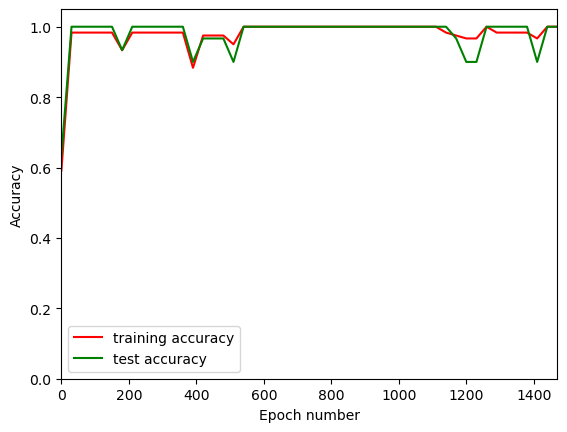

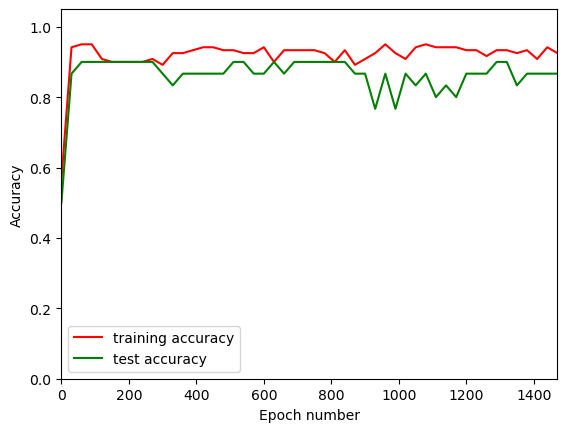

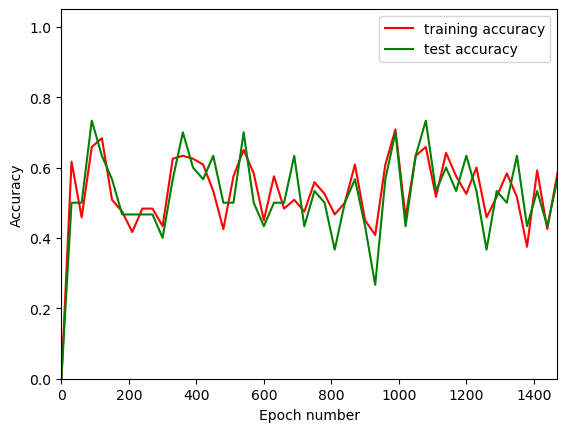

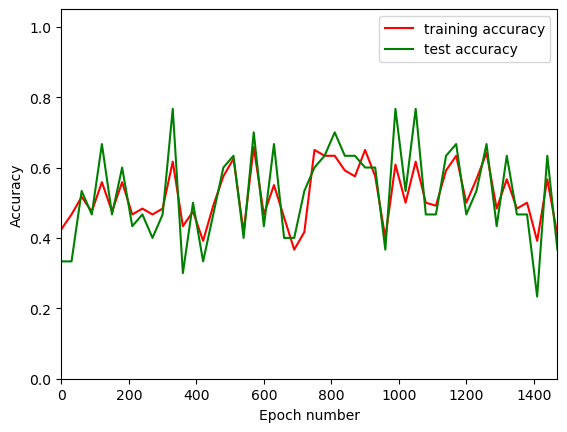

Accuracy: 100.0 %
Accuracy: 95.0 %
Accuracy: 42.5 %
Accuracy: 62.5 %


In [71]:
#Dataset 1
# Step 1: Create Dataset Objects for training and testing
train_dataset1 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset1_train.txt')
train_dataset2 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset2_train.txt')
train_dataset3 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset3_train.txt')
train_dataset4 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset4_train.txt')
test_dataset1 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset1_test.txt')
test_dataset2 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset2_test.txt')
test_dataset3 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset3_test.txt')
test_dataset4 = Dataset(datafile='/Users/a/Eurecom/MALIS/lab3/data/dataset4_test.txt')

# Step 2: Initialize the SVM Model with training and testing datasets
svm_model1 = SVM(train_dataset1, test_dataset1)
svm_model2 = SVM(train_dataset2, test_dataset2)
svm_model3 = SVM(train_dataset3, test_dataset3)
svm_model4 = SVM(train_dataset4, test_dataset4)


# Step 3: Train the SVM Model
svm_model1.train(n_iterations=1500, lambda_w=0.0001, verbose=True)
svm_model2.train(n_iterations=1500, lambda_w=0.0001, verbose=True)
svm_model3.train(n_iterations=1500, lambda_w=0.0001, verbose=True)
svm_model4.train(n_iterations=1500, lambda_w=0.0001, verbose=True)

# Step 4: Make Plot of Accuracy
svm_model1.make_plot()
svm_model2.make_plot()
svm_model3.make_plot()
svm_model4.make_plot()

# Step 5: Print Final Training Accuracy
svm_model1.print_accuracy()
svm_model2.print_accuracy()
svm_model3.print_accuracy()
svm_model4.print_accuracy()


### Question 1.1
Do you find the results that you forecast in Question 0.1?

Your answer here:
Yes, we find pretty much the results we expected, without using any kernel functions.
But the SVM performs significantly better on the polynomial data than we would have expected, because a polynomial of degree 3 can be approximated not too bad by a straight line. It will only fail around the base of the function.

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

### Approximating the Radial Basis Function (RBF) kernel

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

#### Exercise 2.1
Complete the following implementation of the FeaturesMap class.

In [72]:
from utils import Dataset
from math import cos, pi
import random
import numpy as np

class FeaturesMap:

    def __init__(self, D, d, gamma):
        '''
        INPUT:
        - d : old dimensions
        - D : new dimensions
        - gamma : softness/hardness parameter
        '''
        mean = np.zeros(d)
        cov = 2 * d * gamma * np.eye(d)
        self.D = D
        self.w = np.array([np.random.multivariate_normal(mean, cov) for _ in range(D)])
        self.b = np.array([random.random() * 2 * pi for _ in range(D)])

    def __call__(self, dataset):
        outputs = dataset.output
        S_prime = []  # S'
        S = dataset.input
        for x in S:
            # compute z and append the values to S_prime keeping it as a list if you want

            ########## YOUR CODE HERE #################
            z = [cos(np.dot(w, x) + b) for w, b in zip(self.w, self.b)]
            z = np.sqrt(2 / self.D) * np.array(z)
            S_prime.append(z)
            ########## END OF YOUR CODE HERE ##########

        new_data = Dataset(input_size=self.D, length=dataset.len)
        new_data.input = np.array(S_prime)
        new_data.output = outputs

        return new_data


#### Exercise 2.2
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$.

1. Create Dataset() objects for each train and test dataset
2. Move each train and test Dataset() object using FeaturesMap()
3. Init and train SVM with featured map model



Dataset 1


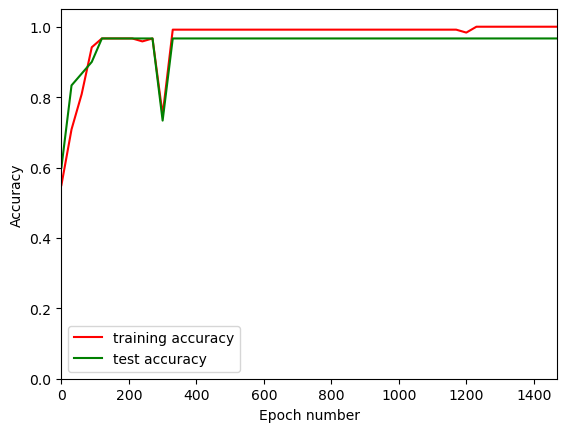

Accuracy: 99.16666666666667 %


Dataset 2


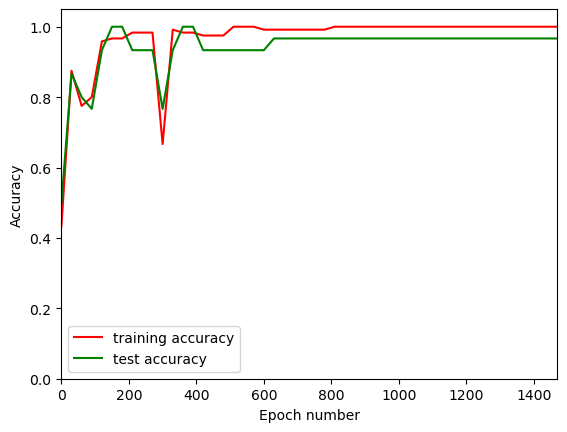

Accuracy: 100.0 %


Dataset 3


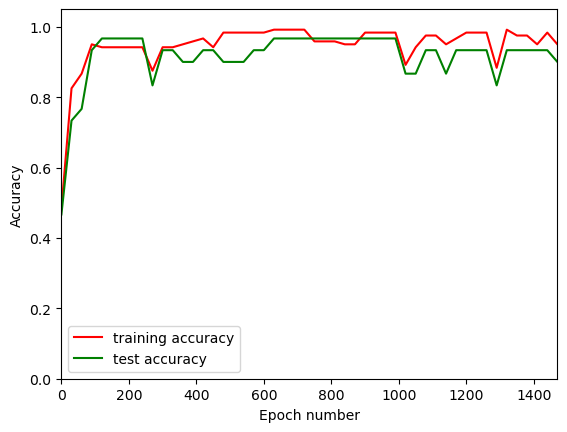

Accuracy: 98.33333333333333 %


Dataset 4


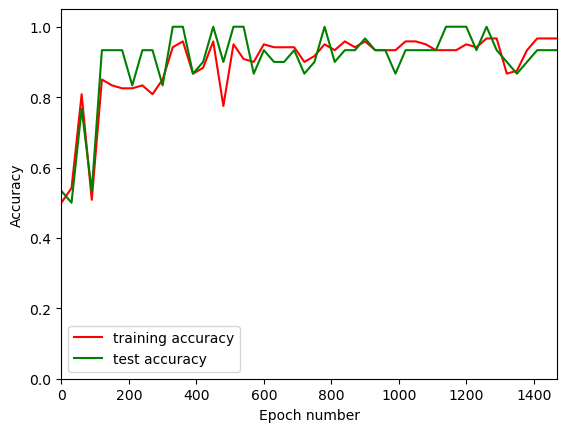

Accuracy: 96.66666666666667 %


In [73]:
from utils import SVM, Dataset

n_iterations=1500
lambda_w = 0.0001
D=200
gamma=1

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    svm = SVM(new_train_data, new_test_data)
    svm.train(n_iterations, lambda_w)
    svm.make_plot()
    svm.print_accuracy()
    ########## END YOUR CODE ############

#### Question 2.1 
How do your results change with respect to what you found in Question 1.1?

Your answer here:
The new model performs very well even with the last two datasets. For the first two datasets the results of the new model are really close to the ones without mapping, but for datasets 3 and 4 the accuracy jumps from lower than 50% to higher than 90%.

### The role of $\gamma$ in the RBF kernel

#### Exercise 2.3
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?



Dataset 1


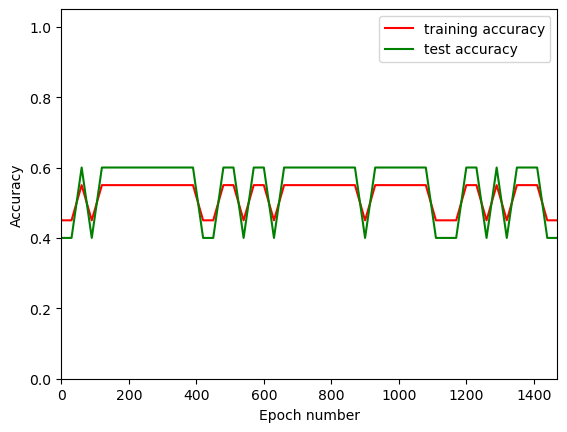

Accuracy: 55.00000000000001 %


Dataset 2


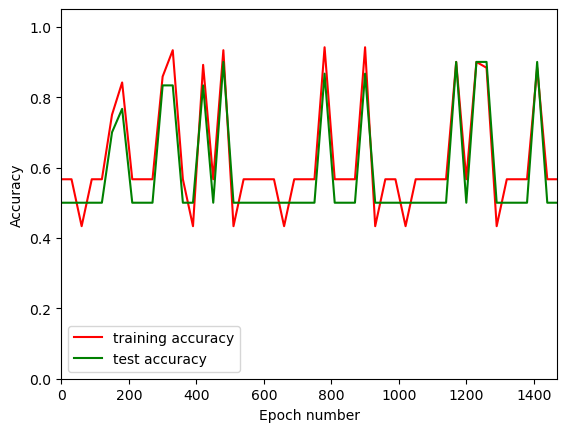

Accuracy: 88.33333333333333 %


Dataset 3


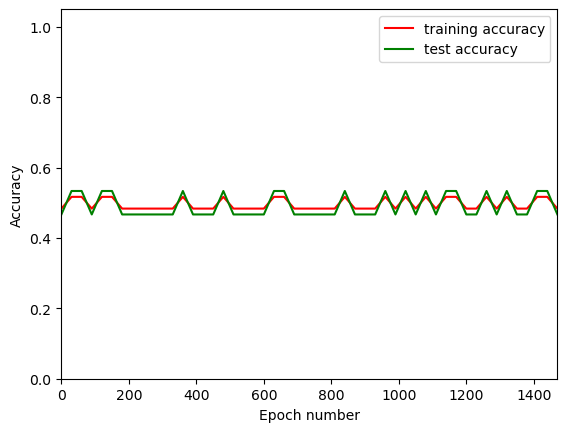

Accuracy: 48.333333333333336 %


Dataset 4


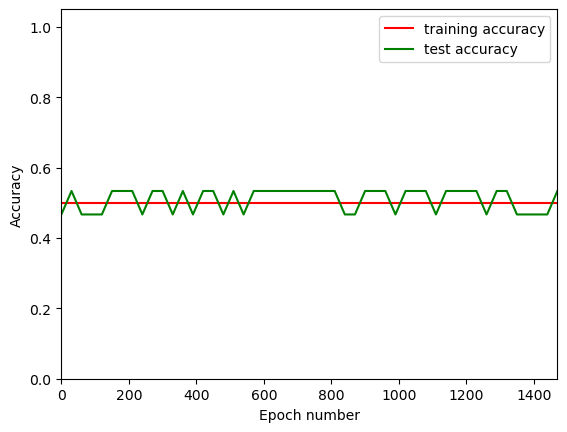

Accuracy: 50.0 %


In [74]:
from utils import SVM, Dataset

n_iterations=1500
lambda_w = 0.0001
D=200
gamma=10e-6

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    svm = SVM(new_train_data, new_test_data)
    svm.train(n_iterations, lambda_w)
    svm.make_plot()
    svm.print_accuracy()
    ########## END YOUR CODE ############

Answer:- 
with $\gamma = 10^{-6}$ the models perform really poorly for all four datasets. Since  influences the covariance used during mapping, the resulting dataset contains values close to 0, with a low variance.


#### Exercise 2.4
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?



Dataset 1


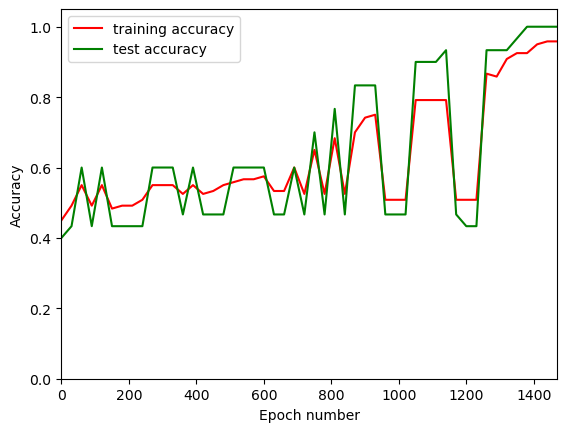

Accuracy: 95.83333333333334 %


Dataset 2


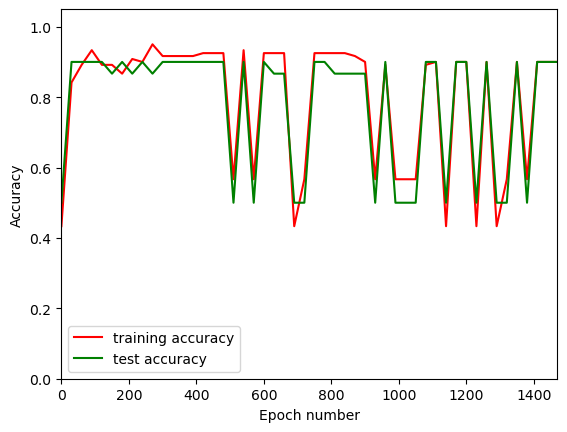

Accuracy: 90.0 %


Dataset 3


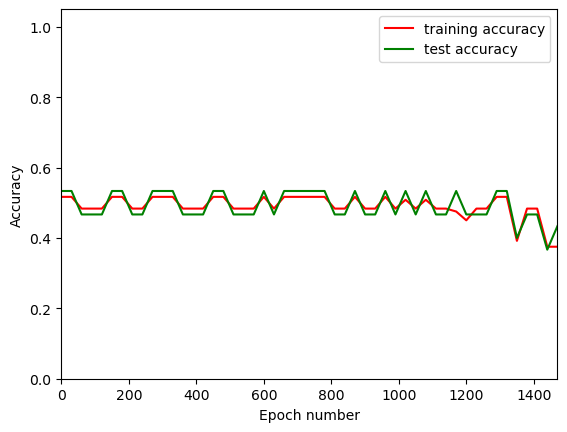

Accuracy: 48.333333333333336 %


Dataset 4


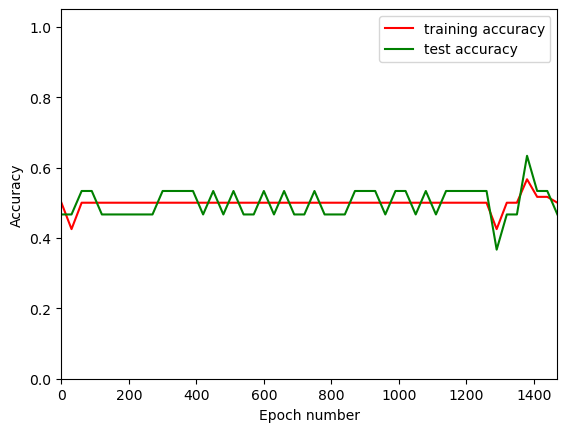

Accuracy: 50.0 %


In [75]:
from utils import SVM, Dataset

n_iterations=1500
lambda_w = 0.0001
D=200
gamma=10e-4

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    svm = SVM(new_train_data, new_test_data)
    svm.train(n_iterations, lambda_w)
    svm.make_plot()
    svm.print_accuracy()
    ########## END YOUR CODE ############

Answer:
with $\gamma = 10^{4}$ the model is clearly overfitting the training data: the accuracy obtained with the training set is good but it is not reflected in the results obtained with the test set. In comparison with $\gamma = 1 $, it also results in  significantly slower increase in training accuracy during training.